In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


In [3]:
# Load the Titanic dataset
titanic = pd.read_csv("/content/titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Removing NAN values

In [4]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
#Age is categorical, so I will use imputing with median
#We already know that passenges with no cabin usually traveled in 3rd class
#thats why we replace missing values with unknown value
#Embarked is categorical value therefore we impute it with mode (=most frequent value)

#imputation on median to reduce bias
titanic['Age'].fillna(titanic['Age'].median(), inplace=True)

#imputation for categorical values based on mode
titanic['Embarked'].fillna(titanic['Embarked'].mode()[0], inplace=True)

#imputation based on our domain knowledge
titanic['Cabin'].fillna("Unknown", inplace=True)

In [6]:
#Optional is to create some new features base on data

titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']
titanic['IsAlone'] = np.where(titanic['FamilySize'] > 0, 0, 1)
titanic['Title'] = titanic['Name'].str.extract(' ([A-Za-z]+)\.') #This is regex, for detail see day 1


In [9]:
#Perform simple feature engineering
#Hint this time do not focus on EDA, outliers etc, for the purpose of exercising more ML methods
#we wont be focusing much on preprocessing
# Encode categorical variables
label_encoders = {}
for col in ['Sex', 'Embarked', 'Cabin', 'Title']:
    label_encoders[col] = LabelEncoder()
    titanic[col] = label_encoders[col].fit_transform(titanic[col])

In [10]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,147,2,1,0,12
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,81,0,1,0,13
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,147,2,0,1,9
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,55,2,1,0,13
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,147,2,0,1,12


In [12]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'IsAlone',
       'Title'],
      dtype='object')

In [13]:
features = ['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'IsAlone',
       'Title']

In [15]:
# Select features and split data into train and test sets
X = titanic[features]
y = titanic['Survived']

print(type(X))
print(type(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [17]:
# Initialize classifiers
#TODO add more classifiers to the dictionary with different parameters
#TODO go through documentation
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Random Forest parametric": RandomForestClassifier(n_estimators= 60, criterion = "gini"),

}

In [19]:
results = []

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy,
        "Classification Report": report,
        "FPR": fpr,
        "TPR": tpr,
        "AUC": roc_auc
    })


In [27]:
results[0].keys()

print(results[0]['TPR'])




[0.         0.7027027  0.74324324 0.75675676 0.77027027 0.77027027
 0.77027027 1.        ]


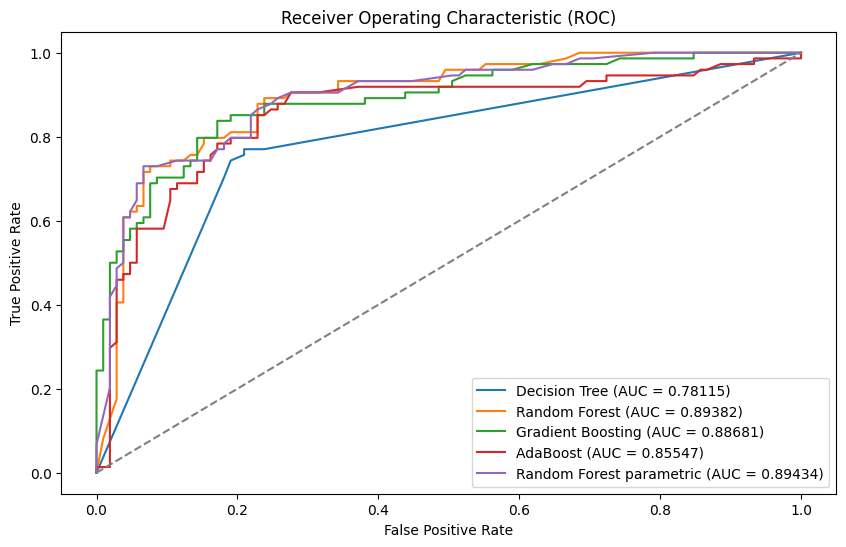

In [29]:
plt.figure(figsize=(10, 6))

for result in results:
    plt.plot(result['FPR'], result['TPR'], label=f"{result['Classifier']} (AUC = {result['AUC']:.5f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()# Plot ROC curves




In [ ]:
# Create a bar chart comparing accuracy


In [ ]:
#Can you create confusion matrix example?